# See Detailed code at https://github.com/aayush9753/ColorIt

## Importing Libraries

In [62]:
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
from torchvision.utils import save_image, make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage import color


## Util

In [63]:
def load_img(img_path):
	out_np = np.asarray(Image.open(img_path))
	if(out_np.ndim==2):
		out_np = np.tile(out_np[:,:,None],3)
	return out_np

def resize_img(img, HW=(256,256), resample=3):
	return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
	# return original size L and resized L as torch Tensors
	img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)
	
	img_lab_orig = color.rgb2lab(img_rgb_orig)
	img_lab_rs = color.rgb2lab(img_rgb_rs)

	img_l_orig = img_lab_orig[:,:,0]
	img_l_rs = img_lab_rs[:,:,0]

	tens_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
	tens_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]

	return (tens_orig_l, tens_rs_l)

def postprocess_tens_new(tens_orig_l, out_ab, mode='bilinear'):
	# tens_orig_l 	Batchsize x 1 x H_orig x W_orig
	# out_ab 		Batchsize x 2 x H x W
    Batchsize = tens_orig_l.shape[0]

    output_ = []
    for i in range(Batchsize):
        tens_orig_l_i = tens_orig_l[i][np.newaxis, :, :, :]
        out_ab_i  = out_ab[i][np.newaxis, :, :, :]
        HW_orig_i = tens_orig_l_i.shape[2:]
        HW_i = out_ab_i.shape[2:]

        # call resize function if needed
        if(HW_orig_i[0]!=HW_i[0] or HW_orig_i[1]!=HW_i[1]):
            out_ab_orig_i = F.interpolate(out_ab_i, size=HW_orig_i, mode='bilinear')
        else:
            out_ab_orig_i = out_ab_i

        out_lab_orig_i = torch.cat((tens_orig_l_i, out_ab_orig_i), dim=1)
        output_.append(color.lab2rgb(out_lab_orig_i.data.cpu().numpy()[0,...].transpose((1,2,0))))
        # output_.append(color.lab2rgb(out_lab_orig_i.data.cpu().numpy()[0,...].transpose((1,2,0))).transpose((2,0,1)))
    return np.array(output_)

# Models
## ECV16
This Model is based on the paper Colorful Image Colorization https://arxiv.org/abs/1603.08511 which we will train using a GAN with the ECV Model (A normal residual convnet model proposed in the paper) as the generator and a discriminator that we will design.

In [64]:
class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm


class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))

def eccv16(pretrained=True):
	model = ECCVGenerator()
	if(pretrained):
		import torch.utils.model_zoo as model_zoo
		model.load_state_dict(model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth',map_location='cpu',check_hash=True))
	return model


# Initialising Models and Training Params

In [65]:
class color_ecv(nn.Module):
    def __init__(self, in_channels):
        super(color_ecv, self).__init__()
        
        self.model = eccv16(pretrained=True)
    
    def forward(self, x):
        ecv_output = self.model(x)
        return ecv_output

In [66]:
shape = (400, 400)
# Initialize generator and discriminator
generator = color_ecv(in_channels = 3)

In [67]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from PIL import Image

device = torch.device('cpu')
modelnum = 60
generator.load_state_dict(torch.load(f'models/generator_{modelnum-1}.pth', map_location=device))
# model = torch.load(f'models/generator{modelnum}_Full.pth')
generator.eval()
generator.to(device)

filename = ['05','07','12','15','20','22','25','39','50','89']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 18744 pixels
  return func(*args, **kwargs)


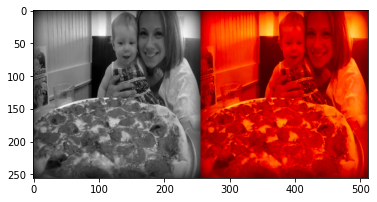

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 8815 pixels
  return func(*args, **kwargs)


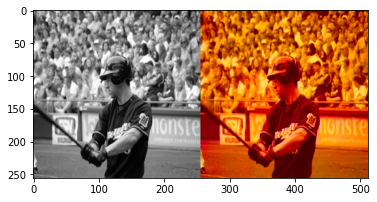

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 15710 pixels
  return func(*args, **kwargs)


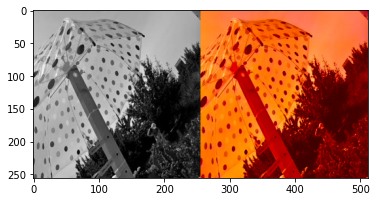

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 6030 pixels
  return func(*args, **kwargs)


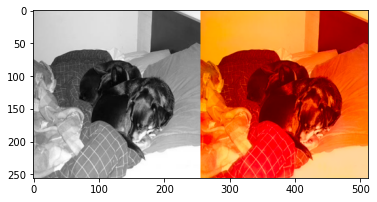

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 5179 pixels
  return func(*args, **kwargs)


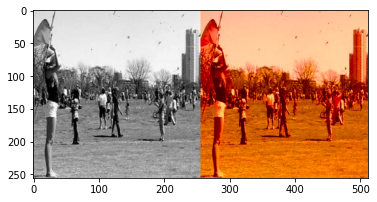

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 13104 pixels
  return func(*args, **kwargs)


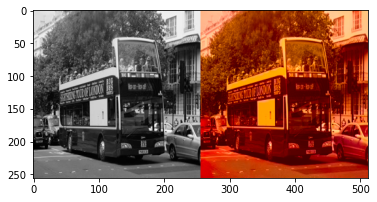

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 4666 pixels
  return func(*args, **kwargs)


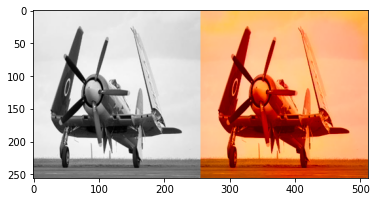

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1113 pixels
  return func(*args, **kwargs)


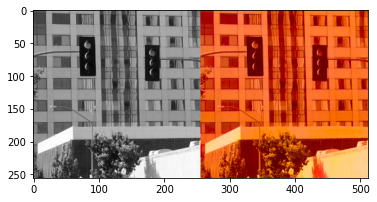

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1181 pixels
  return func(*args, **kwargs)


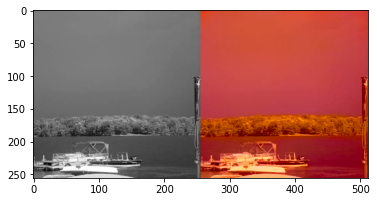

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2834 pixels
  return func(*args, **kwargs)


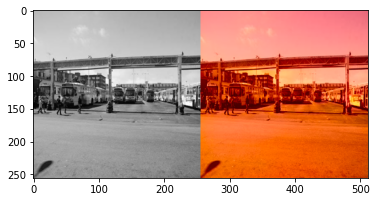

In [68]:

for filename in filename:
    
    input_image = np.asarray(Image.open(f'data/test_black/image50{filename}.jpg'))
    # print(input_image[0])

    color_img = F.to_tensor(Image.open(f'data/test_color/image50{filename}.jpg'))
    
    if input_image.ndim == 2:
        input_image = np.tile(input_image[:,:,None],3)
    
    orig, black= preprocess_img(input_image)
    
    #print(black)

    # Resize and normalize the input image
    # black = F.resize(black, (400, 400))
    # black


    gen_ab = generator(black)
    #print(type(gen_ab))
    #print(gen_ab.shape)
    #print(black.shape)

    gen_color = postprocess_tens_new(black, gen_ab)
    #print(type(gen_color),'\n', gen_color.shape,'\n',gen_color[0][0])
    gen_color = torch.from_numpy(gen_color)
    #print('\n\n', gen_color[0][0])



    #print(gen_color.shape)
    gen_color = gen_color.squeeze().permute((2,0,1))
    
    gen_color = make_grid(gen_color.detach(), nrow=1, normalize=True)
    imgs_black_orig = make_grid(black, nrow=1, normalize=True)
    img_color_orig = make_grid(color_img, nrow=1, normalize=True)

    #print(gen_color.shape)
    #print(imgs_black_orig.shape)

    img_grid = torch.cat((imgs_black_orig, gen_color), -1)
    # save_image(img_grid, f"data/output/output50{filename}_{modelnum}.png", normalize=False)
    #print(img_grid.shape)

    transform = transforms.ToPILImage()
    img = transform(img_grid)
    plt.imshow(img)
    plt.show()

In [69]:
print(imgs_black_orig.shape, gen_color.shape, img_color_orig.shape)

torch.Size([3, 256, 256]) torch.Size([3, 256, 256]) torch.Size([3, 400, 400])
